In [9]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import glob
from itertools import accumulate, starmap, islice
import pandas as pd
from copy import deepcopy
from mpmath import mp; mp.dps = 120; mp.prec =300
from oil.utils.utils import multiGen, cur
from oil.utils.utils import cosLr
from oil.extra.eigen2 import oja_grad,oja_grad2, SGHA_grad,SGHA_grad2, GradLoader
from oil.extra.eigen2 import SGD,SVRG#, H_gen
from oil.lazy.lazy_matrix import lazy, LazyMatrix
#from oil.extra.mvm import flatten, unflatten_like, autoHvpBatch, autoFvpBatch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
float_type = np.float64
## Toy Problem 2 for stochastic eigen decomposition
## PCA
mb = 1000
rank = 100
n = int(1e6)
toy_eigs2 = np.sqrt(.9*np.ones(rank))
toy_eigs2[0] = 1
toy_eigs2[:10] = np.array([1.1,.95,.7,.5,.3,.01,.001,-.4,-.7,-.94]).astype(np.float32)
S = np.diag(toy_eigs2)
#U = torch.ones(rank,1e6).normal_().numpy()
U = np.random.randn(n,rank).astype(float_type)
U,_ = np.linalg.qr(U)
V = np.random.randn(rank,rank).astype(float_type)
V,_ = np.linalg.qr(V)
#V = V.astype(np.float64)
X = (np.sqrt(n)*U@S@V.T).astype(float_type)
cov = X.T@X/n

index = toy_eigs2.argmax()
v = V.T[index]

def toy_A():
    indices = np.random.permutation(n).reshape(n//mb,mb)
    for batch_ids in indices:
        m = len(batch_ids)
        x = X[batch_ids]
        yield [lambda v: (1/m)*x.T@(x@v)]
        
grads = GradLoader(oja_grad, multiGen(toy_A))

In [18]:
sins = []
lrs = []
grad_norms = []
ws = []
sin_pair = lambda u, w: 1-((u@w)**2 /((w@w)*(u@u)))
sin2 = lambda w: sin_pair(v,w)
#sin2 = lambda w: np.linalg.norm(v-w/np.linalg.norm(w))
def grad_norm(w):
    Aw = cov@w
    grad = Aw - (w@Aw)*w
    return np.linalg.norm(grad)

log = lambda w,lrr,_: (sins.append(sin2(w)),grad_norms.append(grad_norm(w)),
                       lrs.append(lrr),ws.append(w))

In [23]:
w0 = np.random.randn(rank)
w0 /= np.linalg.norm(w0)

lr = lambda e: .3*.5#*cosLr(num_epochs)(e)
num_epochs = 10

w = SVRG(grads,w0,lr,num_epochs,log)

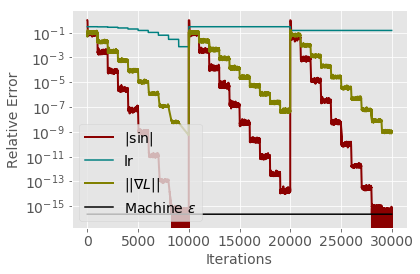

In [24]:
w_avgs = list(starmap(lambda a,b: b/a, enumerate(accumulate(ws[int(1.5*len(sins)/4):]), 1)))
avg_sins = [sin2(w) for w in w_avgs]
colors = ['olive', 'teal', 'darkred']
plt.style.use('ggplot')
f = plt.figure()
plt.plot(sins, lw=2,color=colors[2])
plt.plot(lrs,color=colors[1])
#plt.plot(np.arange(len(sins))[-len(avg_sins):], np.array(avg_sins))
plt.plot(grad_norms, lw=2, color=colors[0])
plt.plot(np.finfo(np.float64).eps*np.ones(len(sins)),color='k')
plt.yscale('log')
plt.ylabel('Relative Error',fontsize=14)
plt.xlabel("Iterations",fontsize=14)
#plt.xscale('log')
#plt.axhline(y=2.22e-16,label = r"Machine $\epsilon$",color='k')
#plt.axhline(y=2.22e-16,label = r"Machine $\epsilon$",color='k')
plt.legend([r"$|\sin|$", "lr",#r"SWA_$|\sin|$",
            r"$||\nabla L||$",r"Machine $\epsilon$"],loc=3,fontsize=14)
#plt.title("Top Eigenvector with Oja+SVRG")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
f.savefig("Oja_convergence.pdf", bbox_inches='tight')

In [25]:
## Toy Problem 3 for stochastic generalized eigen problem
## PCA
mb = 1000
rank = 10
n = int(1e5)

#ideal_diag = np.abs(np.diag(2*np.random.randn(rank)+.5))# np.abs(np.eye(rank))#
ideal_diag = np.abs(np.eye(rank))
R = np.random.randn(rank,rank)
R,_ = np.linalg.qr(R)
B_ideal = R.T@ideal_diag@R

Y = np.random.multivariate_normal(np.zeros(rank),B_ideal,n)
B = Y.T@Y/n

toy_eigs3 = np.sqrt(.9*np.ones(rank))
#toy_eigs3[0] = 1
toy_eigs3[:10] = np.array([1.1,.95,.7,.5,.3,.01,.001,.4,.7,.94])
S = np.diag(toy_eigs3)
#U = torch.ones(rank,1e6).normal_().numpy()
U = np.random.randn(n,rank)
U,_ = np.linalg.qr(U)
V = np.random.randn(rank,rank)
V,_ = np.linalg.qr(V)
invSqrtB = sp.linalg.fractional_matrix_power(B,-1/2)
V = invSqrtB@V # So that V.T@B@V = I (B orthogonal)
X = (np.sqrt(n)*U@S@(B@V).T)
A = X.T@X/n
index = toy_eigs3.argmax()
v = V.T[index]
v = v/np.sqrt(v@B@v)
def toy_AB1():
    indices = np.random.permutation(n).reshape(n//mb,mb)
    for batch_ids in indices:
        m = len(batch_ids)
        x = X[batch_ids]; At = lambda v: (1/m)*x.T@(x@v)
        y = Y[batch_ids]; Bt = lambda v: (1/m)*y.T@(y@v)
        yield [At, Bt]

def toy_AB2():
    Bt_ = lambda v: B@v
    indices = np.random.permutation(n).reshape(n//mb,mb)
    for batch_ids in indices:
        m = len(batch_ids)
        x = X[batch_ids]; At = lambda v: (1/m)*x.T@(x@v)
        y = Y[batch_ids]; Bt = lambda v: (1/m)*y.T@(y@v)
        yield [At,Bt,Bt_]
        Bt_ = deepcopy(Bt)
        
grads = GradLoader(SGHA_grad, multiGen(toy_AB1))

In [26]:
sins = []
lrs = []
grad_norms = []
ws = []
#sin_pair = lambda u, w: 1-(u@B@w)**2 /((w@B@w)*(u@B@u))
#sin2 = lambda w: np.sqrt(sin_pair(v,w))
sin = lambda w: np.linalg.norm(v-w/np.sqrt(w@B@w))
cos = lambda u,w: (u/np.sqrt(u@B@u))@B@(w/np.sqrt(w@B@w))
#sin = lambda w: np.float64(mp.sqrt(mp.fabs(mp.mpf(1)-mp.mpf(str(cos(v,w)))**2)))
#sin = lambda w: np.sqrt(np.abs(1 - cos(v,w)**2))
def grad_norm(w):
    Aw = A@w
    grad = Aw - (w@Aw)*B@w
    return np.linalg.norm(grad)

log = lambda w,lrr,g: (sins.append(sin(w)),grad_norms.append(grad_norm(w)),
                       lrs.append(lrr),ws.append(w))

In [27]:
w0 = np.random.randn(rank)
w0 /= np.sqrt(w0@B@w0)

lr = lambda e: 1e-1#*cosLr(num_epochs)(e)
num_epochs = 15

w = SVRG(grads,w0,lr,num_epochs,log)
w /= np.sqrt(w@B@w)

Text(0.5, 1.0, 'Top Generalized Eigenvector with SGHA+SVRG')

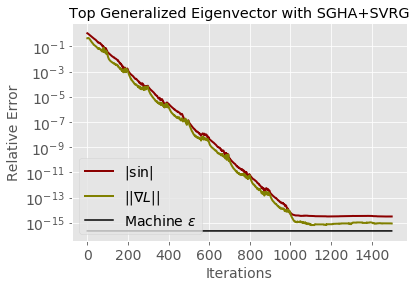

In [28]:
w_avgs = list(starmap(lambda a,b: b/a, enumerate(accumulate(ws[int(1.5*len(sins)/4):]), 1)))
avg_sins = [sin2(w) for w in w_avgs]
colors = ['olive', 'teal', 'darkred']
plt.style.use('ggplot')
f = plt.figure()
plt.plot(sins, lw=2,color=colors[2])
#plt.plot(lrs,color=colors[1])
#plt.plot(np.arange(len(sins))[-len(avg_sins):], np.array(avg_sins))
plt.plot(grad_norms, lw=2, color=colors[0])
plt.plot(np.finfo(np.float64).eps*np.ones(len(sins)),color='k')
plt.yscale('log')
plt.ylabel('Relative Error',fontsize=14)
plt.xlabel("Iterations",fontsize=14)
#plt.xscale('log')
#plt.axhline(y=2.22e-16,label = r"Machine $\epsilon$",color='k')
#plt.axhline(y=2.22e-16,label = r"Machine $\epsilon$",color='k')
plt.legend([r"$|\sin|$",# "lr",#r"SWA_$|\sin|$",
            r"$||\nabla L||$",r"Machine $\epsilon$"],loc=3,fontsize=14)
#plt.title("Top Eigenvector with Oja+SVRG")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
f.savefig("SGHA_convergence.pdf", bbox_inches='tight')
plt.title("Top Generalized Eigenvector with SGHA+SVRG")

In [ ]:
from oil.cnnTrainer import CnnTrainer
from oil.datasets import CIFAR10, C10augLayers
from oil.networkparts import layer13, ConvSmallNWN

In [ ]:
train_epochs = 150
net_config =        {'numClasses':10}
opt_config =        {'lr':.1, 'momentum':.9, 'weight_decay':1e-4, 'nesterov':True}
sched_config =      {'cycle_length':train_epochs,'cycle_mult':1}
trainer_config =    {'amntLab':1, 'amntDev':5000,'dataseed':0,
                    'lab_BS':50, 'num_workers':4, 'log':False, 
                    }
trainer_config['description'] = "13Layer network, {} dev".format(trainer_config['amntDev'])
savedir = None#'/home/maf388/tb-experiments/layer13dev/'

def makeTrainer():
    CNN = ConvSmallNWN(**net_config)
    fullCNN = nn.Sequential(C10augLayers(),CNN)
    datasets = CIFAR10(aug=False)
    opt_constr = lambda params: optim.SGD(params, **opt_config)
    lr_lambda = cosLr(**sched_config)
    return CnnTrainer(fullCNN, datasets, opt_constr, lr_lambda, **trainer_config)

In [ ]:
trainer = makeTrainer()
trainer.load_checkpoint('/home/maf388/tb-experiments/layer13nwn/checkpoints/c.150.ckpt')
_ = trainer.CNN.eval()
trainer.getAccuracy(trainer.dev)

In [ ]:
import inspect

In [ ]:
inspect.getcallargs(trainer.__init__)

In [ ]:
class myslice(object):
    def __init__(self, dataloader, k):
        self.k = k
        self.dloader = dataloader
    def __iter__(self):
        return islice(iter(self.dloader),self.k)

In [ ]:
lrs = []
grad_norms = []
i = 0
def grad_norm(w):
    Aw = A@w
    grad = Aw - (w@Aw)*B@w
    return np.linalg.norm(grad)

def log(w,lr,full_grad):
    global i
    i+=1
    if i%10==0:
        lrs.append(lr)
        grad_norms.append(full_grad.norm())
    pass
#train_loader = myslice(trainer.train_iter,10)
train_loader = myslice(trainer.dev,5)
H_loader = multiGen(lambda:H_gen(train_loader,trainer.CNN))
grads = GradLoader(oja_grad2,H_loader)

In [ ]:
for k in train_loader:
    pass#print(k)

In [ ]:
p = flatten(trainer.CNN.parameters())
w0 = torch.zeros_like(p)
w0.normal_()
w0 = w0/w0.norm()
lr = lambda e: 1e-4#*cosLr(num_epochs)(e)
num_epochs = 10

w = SVRG(grads,w0,lr,num_epochs,log)
lam = w@w
w /= w.norm()

In [ ]:
grad_norms

In [ ]:
plt.plot(lrs)
plt.plot(grad_norms)
plt.plot(np.finfo(np.float64).eps*np.ones(len(lrs)),color='k')
plt.yscale('log')
plt.ylabel('Relative Error')
plt.xlabel("Iterations")
#plt.xscale('log')
plt.legend(["lr",r"$||\nabla L||$",r"Machine $\epsilon$"],loc=3)

In [ ]:
w@B@v

In [ ]:
w@A@w

In [ ]:
print(q)

In [ ]:
import torch

In [ ]:
if torch.Tensor: print("hello")